In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dropout, Dense,
                                     LSTM, Reshape, BatchNormalization, Input,
                                     Bidirectional)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
data_train_path = 'Dataset/Train'
data_val_path = 'Dataset/Validation'
data_test_path = 'Dataset/Test'

In [5]:
img_width = 224
img_height = 224
batch_size = 32

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    validation_split=0.5,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)

# Load validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    label_mode='binary'
)

# Load test data
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size=batch_size,
    label_mode='binary'
)

Found 140002 files belonging to 2 classes.
Using 70001 files for training.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [6]:
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [8]:
def build_hybrid_model(input_shape=(img_height, img_width, 3)):
    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze pre-trained layers

    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, -1))(x)  # Shape for LSTM: (batch, time_steps=1, features)

    x = Bidirectional(LSTM(128))(x)
    x = Dropout(0.4)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [9]:
model = build_hybrid_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [12]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint(
        filepath='best_model_cnn_lstm.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1382s 632ms/step - accuracy: 0.7416 - auc: 0.8185 - loss: 0.5270 - val_accuracy: 0.7257 - val_auc: 0.8446 - val_loss: 0.5385 - learning_rate: 1.0000e-04
Epoch 2/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1391s 636ms/step - accuracy: 0.7544 - auc: 0.8357 - loss: 0.4993 - val_accuracy: 0.7422 - val_auc: 0.8504 - val_loss: 0.5139 - learning_rate: 1.0000e-04
Epoch 3/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1386s 634ms/step - accuracy: 0.7688 - auc: 0.8502 - loss: 0.4791 - val_accuracy: 0.7579 - val_auc: 0.8582 - val_loss: 0.4889 - learning_rate: 1.0000e-04
Epoch 4/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1399s 639ms/step - accuracy: 0.7747 - auc: 0.8563 - loss: 0.4686 - val_accuracy: 0.7610 - val_auc: 0.8618 - val_loss: 0.4866 - learning_rate: 1.0000e-04
Epoch 5/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2643s 1s/step - accuracy: 0.7795 - auc: 0.8632 - loss: 0.4596 - val_accuracy: 0.7723 - val_auc: 0.8668 - val_loss: 0.4672 - learning_rate: 1.0000e-04
Epoch 6/50
2188/2188 ━━━━━━━━━━━━━━━━━━

In [20]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('CNN+LSTM Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('CNN+LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

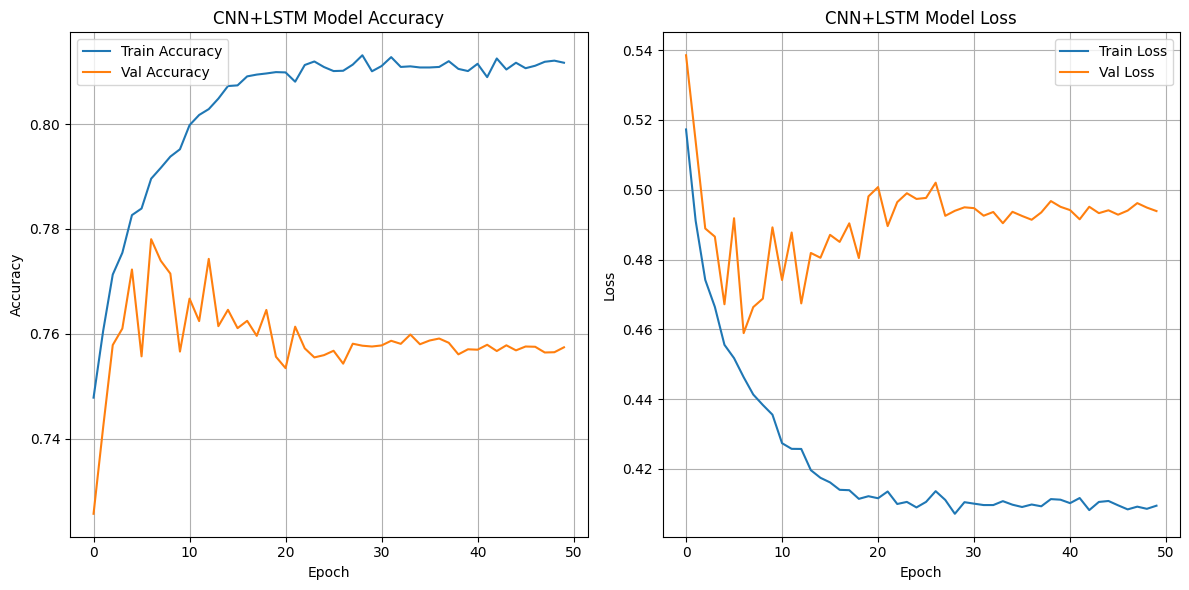

In [21]:

plot_history(history)

In [22]:
model.save('cnn_lstm.keras')